In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [2]:
trace = pandas.read_csv("data/evolution.log", sep=';')
trace["performance"] = trace["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
trace["length"] = trace["score"].apply(lambda s: -float(s[1:-1].split(',')[1]))
trace["rank"] = trace["performance"].rank(method='max')

trace = trace.set_index("id")
trace = trace.sort_values("t_start")
trace["order"] = list(range(len(trace)))
trace["child_count"] = [0] * len(trace)

In [3]:
# Calculate number of children per individual
for _, pipeline in trace.iterrows():
    if isinstance(pipeline["parent0"], str):
        trace.loc[pipeline["parent0"], "child_count"] += 1
    if isinstance(pipeline["parent1"], str):
        trace.loc[pipeline["parent1"], "child_count"] += 1

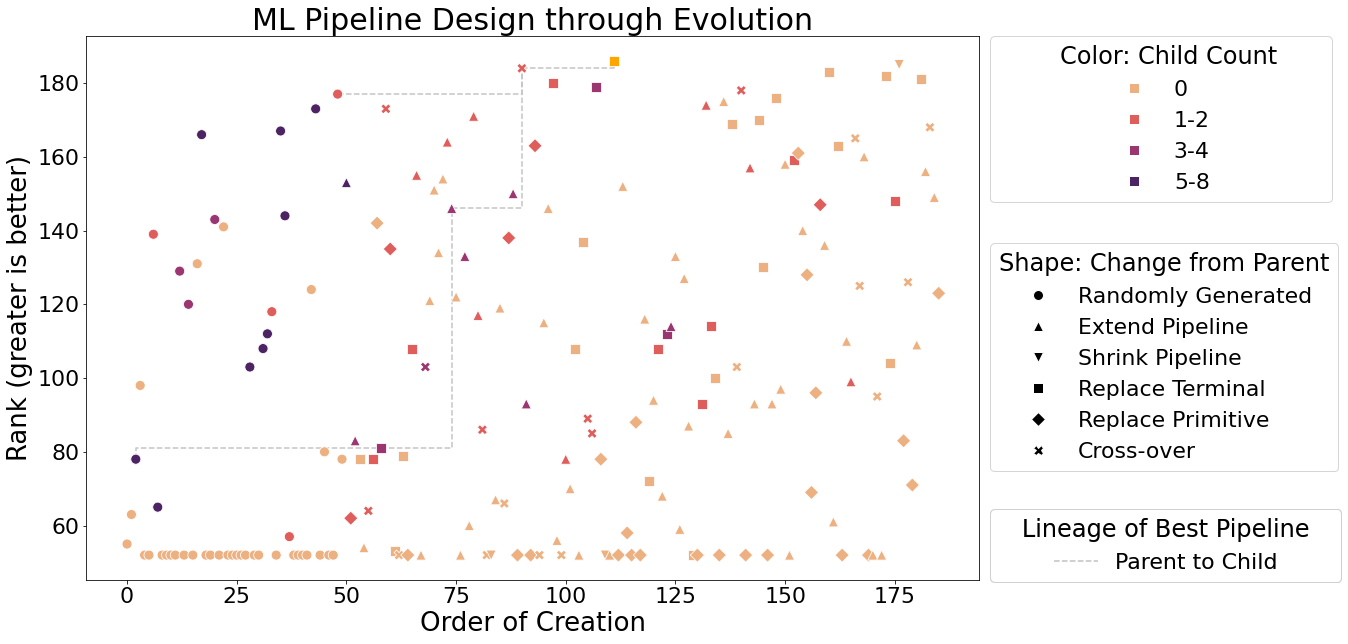

In [26]:
# Code used later to visualize an individual's lineage        
lineages = []
def add_lineage(self, parent):
    lineages.append([[parent["order"], self["order"], self["order"]], [parent["rank"], parent["rank"], self["rank"]]])

def trace_lineage(pipeline):
    if isinstance(pipeline["parent0"], str):
        trace_lineage(trace.loc[pipeline["parent0"]])
        add_lineage(pipeline, trace.loc[pipeline["parent0"]])
    if isinstance(pipeline["parent1"], str):
        trace_lineage(trace.loc[pipeline["parent1"]])
        add_lineage(pipeline, trace.loc[pipeline["parent1"]])


fig, ax = plt.subplots(1, 1, figsize=(16, 10))

marker_map = dict(
    new="o",
    mut_insert="^",
    mut_shrink="v",
    mut_replace_terminal="s",
    mut_replace_primitive="D",
    cx="X",
)

marker_size = 100
scatter_kwargs = dict(
    x="order",
    y="rank",
    style="origin",
    markers=marker_map,
    s=marker_size,
    ax=ax,
)

best   = trace[trace["rank"] == trace["rank"].max()]
others = trace[trace["rank"] != trace["rank"].max()]
trace_lineage(best.iloc[0])

light_grey = "#c4c4c4"
for lineage in lineages:
    if lineage == [[2, 58, 58], [78.0, 78.0, 81.0]]:
        # In this particular configuration trace (evolution.log), the start point 
        # of this lineage shares its rank with a few other individuals,
        # this results in the lineage line crossing some pipeline evaluations which 
        # makes the plot hard to interpret. So we reroute:
        lineage = [[2, 2, 58], [78.0, 81.0, 81.0]]
    ax.plot(*lineage, color=light_grey, zorder=-1, linestyle='dashed')

most_children = trace["child_count"].max()
count_to_color = {
    0: seaborn.color_palette("flare", as_cmap=True)(0),
    1: seaborn.color_palette("flare", as_cmap=True)(0.33),
    2: seaborn.color_palette("flare", as_cmap=True)(0.33),
    3: seaborn.color_palette("flare", as_cmap=True)(0.66),
    4: seaborn.color_palette("flare", as_cmap=True)(0.66),
    5: seaborn.color_palette("flare", as_cmap=True)(0.99),
    6: seaborn.color_palette("flare", as_cmap=True)(0.99),
    7: seaborn.color_palette("flare", as_cmap=True)(0.99),
    8: seaborn.color_palette("flare", as_cmap=True)(0.99),
}
    
seaborn.scatterplot(
    data=others,
    hue="child_count",
    palette=count_to_color,
    **scatter_kwargs
)

seaborn.scatterplot(
    data=best,
    color="orange",
    legend=False,
    **scatter_kwargs,
)


name_map = dict(
    new="Randomly Generated",
    mut_insert="Extend Pipeline",
    mut_shrink="Shrink Pipeline",
    mut_replace_terminal="Replace Terminal",
    mut_replace_primitive="Replace Primitive",
    cx="Cross-over",
)

from matplotlib.lines import Line2D
legend_elements = [
    *[        
        Line2D([0], [0], marker=marker_map[origin], color='w', markerfacecolor='k', markersize=10, label=name)
        for origin, name in name_map.items()
    ],
   #*[Line2D([0], [0], color=color, lw=2, label=learner) for learner, color in learner_to_color.items()],
]

fig.gca().add_artist(
    ax.legend(handles=legend_elements,  fontsize = 22 , bbox_to_anchor=(1,0.18), loc="lower left", 
              title="Shape: Change from Parent",title_fontsize=24)
)

legend_elements = [
    Line2D([0], [0], marker="s", color='w', markerfacecolor=count_to_color[0], markersize=10, label="0"),
    Line2D([0], [0], marker="s", color='w', markerfacecolor=count_to_color[2], markersize=10, label="1-2"),
    Line2D([0], [0], marker="s", color='w', markerfacecolor=count_to_color[4], markersize=10, label="3-4"),
    Line2D([0], [0], marker="s", color='w', markerfacecolor=count_to_color[7], markersize=10, label="5-8"),
   #*[Line2D([0], [0], color=color, lw=2, label=learner) for learner, color in learner_to_color.items()],
]

fig.gca().add_artist(
    ax.legend(handles=legend_elements, fontsize = 22, bbox_to_anchor=(1, 1.02), loc="upper left", 
              title="        Color: Child Count      ",title_fontsize=24)
)

legend_elements = [
    Line2D([0], [0], color=light_grey, linestyle="dashed", label="Parent to Child")
   #*[Line2D([0], [0], color=color, lw=2, label=learner) for learner, color in learner_to_color.items()],
]

fig.gca().add_artist(
    ax.legend(handles=legend_elements, fontsize = 22, bbox_to_anchor=(1,0.15), loc="upper left", 
             title="   Lineage of Best Pipeline   ",title_fontsize=24)
)

ax.set_ylabel("Rank (greater is better)", fontsize=26)
ax.set_xlabel("Order of Creation", fontsize=26)
ax.set_title("ML Pipeline Design through Evolution", fontdict=dict(fontsize=30)) # size='xx-large', 
ax.tick_params(axis='both', which = 'major', labelsize = 22)

**Figure** An graphical representation of the evolutionary optimization of ML pipelines. 

Each **marker** denotes a ML pipeline, the x-value denotes the time of creation, though for clarity the first 50 randomly generated individuals are shown as though they are created in sequence (i.e., 0-50 denote the same point in time). The y-value denotes the pipeline performance ranking (higher is better). 

The **marker style** denotes the origin of the pipeline, e.g., cross-over or mutation, as indicated in the legend (ignore the duplication).

The **lines** represent the lineage of the best found pipeline, since the order of pipelines is denotes by the x-axis, parents are always to the left.

The **color** of the marker indicates how much offspring each pipeline produced, with the exception of the best found pipeline which is highlighted in orange.

In [27]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("lineageplot.pdf") as f:
    f.savefig(fig, bbox_inches='tight')